In [3]:
# Import libraries
import os
import numpy as np
import cv2
import random
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow
from PIL import Image
from skimage import io, feature, color


import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#import segmentation_models as sm

In [63]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


In [4]:
def read_data(data_dir):
  # Initialize lists for images, mask, labels
  images = []
  masks = []
  labels = []
  classes = {'normal': 0, 'benign': 1, 'malignant' : 2}

  for class_name, class_label in classes.items():
      class_dir = os.path.join(data_dir, class_name)
      for image_file in os.listdir(class_dir):
          if image_file.endswith(".png") and 'mask' not in image_file:
              # Load the original image
              image_path = os.path.join(class_dir, image_file)
              images.append(image_path)

              # Find all masks associated with the image
              image_name = os.path.splitext(image_file)[0]# Remove the file extension
              matching_masks = [f for f in os.listdir(class_dir) if f == image_name + '_mask.png']
              for mask_file in matching_masks:
                mask_path = os.path.join(class_dir, mask_file)
                masks.append(mask_path)

              class_label = classes[class_name]
              labels.append(class_name)

  return images, masks, labels



def compute_lbps(images):
    lbps = []
    for image_path in images:
        # Load the original image
        image = io.imread(image_path)

        # Compute LBP for the image
        lbp_image = feature.local_binary_pattern(color.rgb2gray(image), P=8, R=1, method='uniform')
        lbp_image = np.expand_dims(lbp_image, axis = -1)
        lbps.append(lbp_image)

    return lbps

def visualize_images(images, masks, lbps, labels):
    num_samples = len(images)

    for i in range(num_samples):
        # Load original image
        image = io.imread(images[i])

        # Load mask
        mask = io.imread(masks[i])

        # Display original image, mask, and LBP image side by side
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f'Original Image\nLabel: {labels[i]}')

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(lbps[i], cmap='gray')
        plt.title('Local Binary Pattern (LBP)')

        plt.show()





In [6]:
# Assuming you have already called read_data to get images, masks, and labels
data_dir = '/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/data/Dataset_BUSI_with_GT/Original without duplicated, misclassification and axila/balanced_data'
images, masks, labels = read_data(data_dir)

In [7]:

# Compute LBP images separately
lbps = compute_lbps(images)

In [8]:
print(len(images))
print(len(masks))
print(len(labels))
#print(lbps.shape)
print(lbps[0])

894
894
894
[[[1.]
  [1.]
  [9.]
  ...
  [4.]
  [4.]
  [2.]]

 [[4.]
  [4.]
  [9.]
  ...
  [4.]
  [4.]
  [2.]]

 [[4.]
  [3.]
  [5.]
  ...
  [4.]
  [5.]
  [2.]]

 ...

 [[2.]
  [8.]
  [5.]
  ...
  [8.]
  [3.]
  [9.]]

 [[5.]
  [4.]
  [0.]
  ...
  [3.]
  [8.]
  [1.]]

 [[1.]
  [0.]
  [9.]
  ...
  [9.]
  [1.]
  [3.]]]


In [9]:
# Creating dataframe from the generated lists
df = pd.DataFrame({'images': images, 'masks': masks, 'lbps': lbps, 'labels': labels})

train_data, test_data = train_test_split(df, test_size = 0.2, random_state=42, stratify=df['labels'])
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


In [10]:
# Visualize a few samples from the training data
num_samples_to_visualize = 20
visualize_images(train_data['images'][:num_samples_to_visualize],
                 train_data['masks'][:num_samples_to_visualize],
                 train_data['lbps'][:num_samples_to_visualize],
                 train_data['labels'][:num_samples_to_visualize])

Output hidden; open in https://colab.research.google.com to view.

In [114]:
# Visualize a few samples from the training data
num_samples_to_visualize = 20
visualize_images(test_data['images'][:num_samples_to_visualize],
                 test_data['masks'][:num_samples_to_visualize],
                 test_data['lbps'][:num_samples_to_visualize],
                 test_data['labels'][:num_samples_to_visualize])

Output hidden; open in https://colab.research.google.com to view.

In [11]:
# Data processing for train data set
height, width, channels = 128, 128, 3

# Initialize empty arrays for X_train and y_train
X_train_image = np.zeros((len(train_data), height, width, channels), dtype=np.uint8)
X_train_lbp = np.zeros((len(train_data), height, width, 1), dtype=np.uint8)
y_train = np.zeros((len(train_data), height, width, 1), dtype=np.bool)
train_labels = []

# Iterate through the DataFrame to populate X_train and y_train
for idx, row in train_data.iterrows():
    image_path = row['images']
    mask_path = row['masks']
    lbp = row['lbps']
    label_train = row['labels']

    # Load and resize the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (width, height))

    # Load and resize the LBP image
    lbp_resized = cv2.resize(lbp, (width, height))
    # Add a singleton dimension to make it (height, width, 1)
    lbp_resized = np.expand_dims(lbp_resized, axis=-1)

    # Load and resize the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (width, height))
    mask = np.expand_dims(mask, axis=-1)  # Expand dimensions to make it (height, width, 1)

    X_train_image[idx] = image
    X_train_lbp[idx] = lbp_resized
    y_train[idx] = mask
    train_labels.append(label_train)

<ipython-input-11-2c41451960ae>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.zeros((len(train_data), height, width, 1), dtype=np.bool)


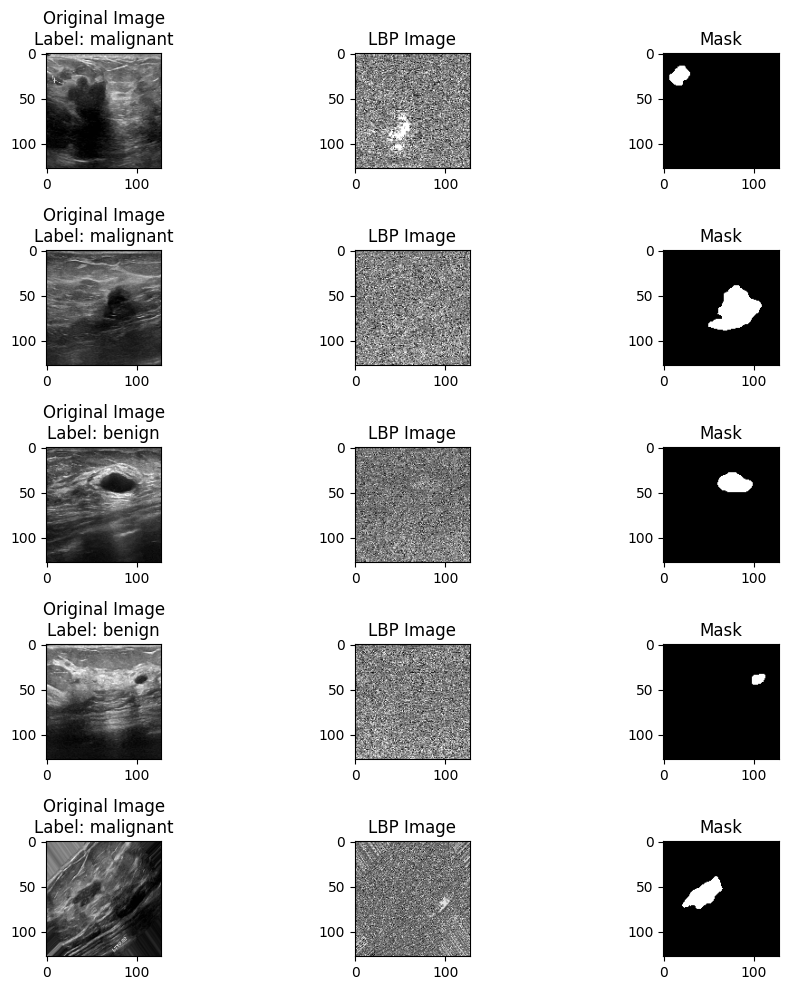

In [119]:
# Define the number of samples you want to plot
num_samples_to_plot = 5

# Create subplots for the images and their corresponding labels
fig, axes = plt.subplots(num_samples_to_plot, 3, figsize=(10, 10))

for i in range(num_samples_to_plot):
    # Randomly select an index from X_train_image, X_train_lbp, and y_train
    idx = np.random.randint(0, len(X_train_image))

    # Get the image, LBP, mask, and label
    image = X_train_image[idx]
    lbp = X_train_lbp[idx]
    mask = y_train[idx]
    label = train_labels[idx]

    # Plot the original image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Original Image\nLabel: {label}")

    # Plot the LBP image
    axes[i, 1].imshow(lbp[:, :, 0], cmap='gray')
    axes[i, 1].set_title("LBP Image")

    # Plot the mask
    axes[i, 2].imshow(mask[:, :, 0], cmap='gray')
    axes[i, 2].set_title("Mask")

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [39]:
print(X_train_image.shape)
print(X_train_lbp.shape)
print(y_train.shape)
print(len(train_labels))

(715, 128, 128, 3)
(715, 128, 128, 1)
(715, 128, 128, 1)
715


In [12]:
# Data processing for test data set
height, width, channels = 128, 128, 3

# Initialize empty arrays
X_test_image = np.zeros((len(test_data), height, width, channels), dtype=np.uint8)
X_test_lbp = np.zeros((len(test_data), height, width, 1), dtype=np.uint8)
y_test = np.zeros((len(test_data), height, width, 1), dtype=np.bool)
test_labels = []

# Iterate through the DataFrame to populate the emtpy arrays
for idx, row in test_data.iterrows():
    image_path = row['images']
    mask_path = row['masks']
    lbp = row['lbps']
    label_test = row['labels']

   # Load and resize the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (width, height))

    # Load and resize the LBP image
    lbp_resized = cv2.resize(lbp, (width, height))
    # Add a singleton dimension to make it (height, width, 1)
    lbp_resized = np.expand_dims(lbp_resized, axis=-1)

    # Load and resize the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (width, height))
    mask = np.expand_dims(mask, axis=-1)  # Expand dimensions to make it (height, width, 1)

    X_test_image[idx] = image
    X_test_lbp[idx] = lbp_resized
    y_test[idx] = mask
    test_labels.append(label_test)

<ipython-input-12-3b6c4badf2f5>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_test = np.zeros((len(test_data), height, width, 1), dtype=np.bool)


In [13]:
print(X_test_image.shape)
print(X_test_lbp.shape)
print(y_test.shape)
print(len(test_labels))

(179, 128, 128, 3)
(179, 128, 128, 1)
(179, 128, 128, 1)
179


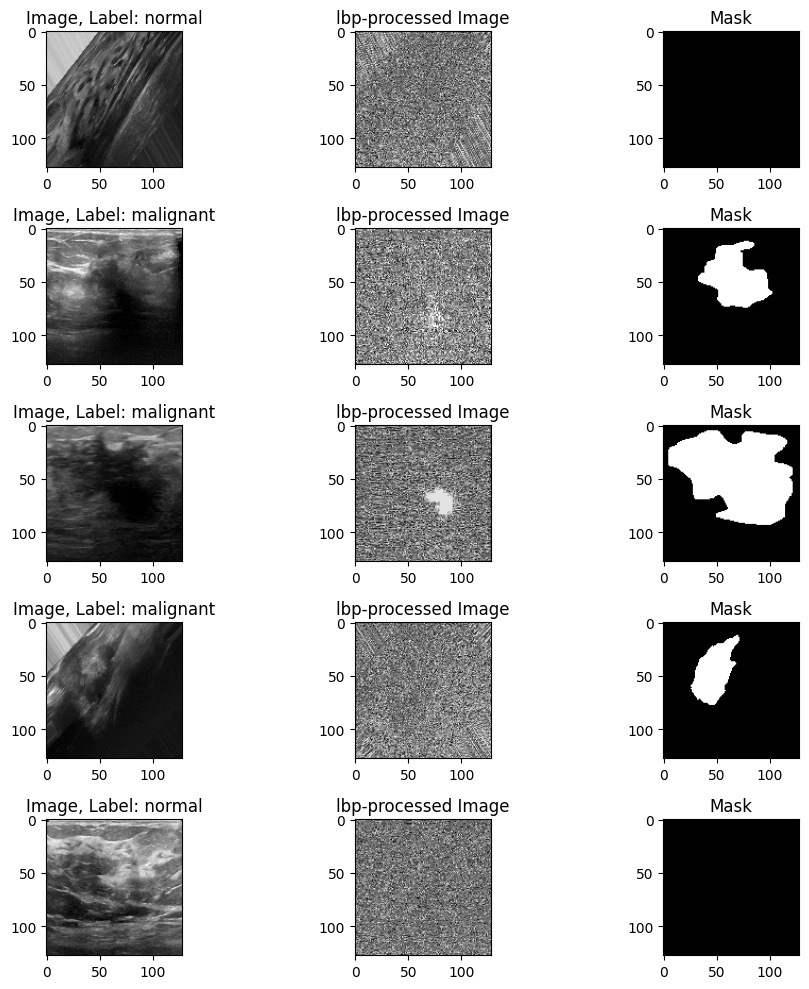

In [112]:

# Define the number of samples you want to plot
num_samples_to_plot = 5

# Create subplots for the images and their corresponding masks
fig, axes = plt.subplots(num_samples_to_plot, 3, figsize=(10, 10))

for i in range(num_samples_to_plot):
    # Randomly select an index from X_train and y_train
    idx = np.random.randint(0, len(X_train_image))

    # Get the image and mask
    image = X_train_image[idx]
    lbp = X_train_lbp[idx]
    mask = y_train[idx]

    # Plot the image
    axes[i, 0].imshow(image, cmap = 'gray')
    axes[i, 0].set_title(f"Image, Label: {train_labels[idx]}")

    # Plot the lbp
    axes[i, 1].imshow(lbp, cmap = 'gray')
    axes[i, 1].set_title("lbp-processed Image")

    # Plot the mask
    axes[i, 2].imshow(mask[:, :, 0], cmap='gray')
    axes[i, 2].set_title("Mask")

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [47]:
batch_size = 8
learning_rate = 0.0001
epochs = 100
width, hight, channels = X_train_image.shape[1:]

In [48]:
# Defining input layer and convert it to a floating naumber

inputs_image = tf.keras.layers.Input((width, height, channels))
inputs_lbp = tf.keras.layers.Input((width, height, 1))
combined_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs_image, inputs_lbp])
s = tf.keras.layers.Lambda(lambda x: x/255)(combined_inputs) # Convert uint8 to float

In [ ]:
print(combined_inputs.shape)

In [49]:
# Contracting Path/Encoder
# Dropout Layers to avoid overfitting
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c5)

# Expansive Path/Decoder
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = 'same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = 'same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis =3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)


In [50]:
model = tf.keras.Model(inputs=[inputs_image, inputs_lbp], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 concatenate_6 (Concatenate  (None, 128, 128, 4)          0         ['input_6[0][0]',             
 )                                                                   'input_7[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 128, 128, 4)          0         ['concatenate_6[0][0]'] 

In [51]:
# Callbacks
# ModelCheckpoint: save after every epoch the model, only if it is better than the previous one
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/models/lbp_original_unet.h5', verbose = 1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs/lbp_original_unet/')
    ]

In [52]:
results = model.fit([X_train_image, X_train_lbp], y_train, validation_split=0.1, batch_size=batch_size, epochs = epochs, callbacks=callbacks)

Epoch 1/100
81/81 [==============================] - ETA: 0s - loss: 0.2851 - accuracy: 0.9077
Epoch 1: val_loss improved from inf to 0.20927, saving model to /content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/models/lbp_original_unet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 112s 1s/step - loss: 0.2851 - accuracy: 0.9077 - val_loss: 0.2093 - val_accuracy: 0.9397
Epoch 2/100
81/81 [==============================] - ETA: 0s - loss: 0.2312 - accuracy: 0.9181
Epoch 2: val_loss improved from 0.20927 to 0.19224, saving model to /content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/models/lbp_original_unet.h5
81/81 [==============================] - 115s 1s/step - loss: 0.2312 - accuracy: 0.9181 - val_loss: 0.1922 - val_accuracy: 0.9397
Epoch 3/100
81/81 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9181
Epoch 3: val_loss improved from 0.19224 to 0.18729, saving model to /content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/models/lbp_original_unet.h5
81/81 [==============================] - 134s 2s/step - loss: 0.2104 - accuracy: 0.9181 - val_loss: 0.1873 - val_accuracy: 0.9397
Epoch 4/100
81/81 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 

In [56]:

X_train_image_2 = X_train_image[:int(X_train_image.shape[0]*0.9)]
X_val_image = X_train_image[int(X_train_image.shape[0]*0.9):]

X_train_lbp_2 = X_train_lbp[:int(X_train_lbp.shape[0]*0.9)]
X_val_lbp = X_train_lbp[int(X_train_lbp.shape[0]*0.9):]

# Predict using X_train, and 0.1 of X_train as validation, and X_test
preds_train = model.predict([X_train_image_2, X_train_lbp_2], verbose =1)
preds_val = model.predict([X_val_image, X_val_lbp], verbose =1)
preds_test = model.predict([X_test_image, X_test_lbp], verbose =1)

# Threshold the predicted mask to create binary masks
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

6/6 [==============================] - 11s 2s/step


In [57]:
# Calculate evaluation metrics on
iou = []
dice = []
precision = []
recall = []
f1 = []

for i in range(len(X_test_image)):
    iou.append(tf.keras.metrics.MeanIoU(num_classes=2)(y_test[i], preds_test_t[i]).numpy())
    dice.append(2 * np.sum(y_test[i] * preds_test_t[i]) / (np.sum(y_test[i]) + np.sum(preds_test_t[i])))
    precision.append(precision_score(y_test[i].flatten(), preds_test_t[i].flatten()))
    recall.append(recall_score(y_test[i].flatten(), preds_test_t[i].flatten()))
    f1.append(f1_score(y_test[i].flatten(), preds_test_t[i].flatten()))

# Calculate the average metrics
average_iou = np.mean(iou)
average_dice = np.mean(dice)
average_precision = np.mean(precision)
average_recall = np.mean(recall)
average_f1 = np.mean(f1)

print(f'Average IoU: {average_iou}')
print(f'Average Dice Coefficient: {average_dice}')
print(f'Average Precision: {average_precision}')
print(f'Average Recall: {average_recall}')
print(f'Average F1 Score: {average_f1}')

<ipython-input-57-98978c4442c4>:10: RuntimeWarning: invalid value encountered in double_scalars
  dice.append(2 * np.sum(y_test[i] * preds_test_t[i]) / (np.sum(y_test[i]) + np.sum(preds_test_t[i])))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control

Average IoU: 0.7454288601875305
Average Dice Coefficient: nan
Average Precision: 0.44664719728689195
Average Recall: 0.4978530432287948
Average F1 Score: 0.4462205004676408


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-57-98978c4442c4>:10: RuntimeWarning: invalid value encountered in double_scalars
  dice.append(2 * np.sum(y_test[i] * preds_test_t[i]) / (np.sum(y_test[i]) + np.sum(preds_test_t[i])))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

In [61]:
# Visualize some of the test images, ground truth masks, and predicted masks
num_samples_to_visualize = 15  # Number of samples to visualize

for i in range(num_samples_to_visualize):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(X_test_image[i], cmap = 'gray')
    plt.title(f'Test Image\nLabel: {test_labels[i]}')

    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title('Ground Truth Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(preds_test_t[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

# Print the average metrics
print(f'Average IoU: {average_iou}')
print(f'Average Dice Coefficient: {average_dice}')
print(f'Average Precision: {average_precision}')
print(f'Average Recall: {average_recall}')
print(f'Average F1 Score: {average_f1}')

Output hidden; open in https://colab.research.google.com to view.

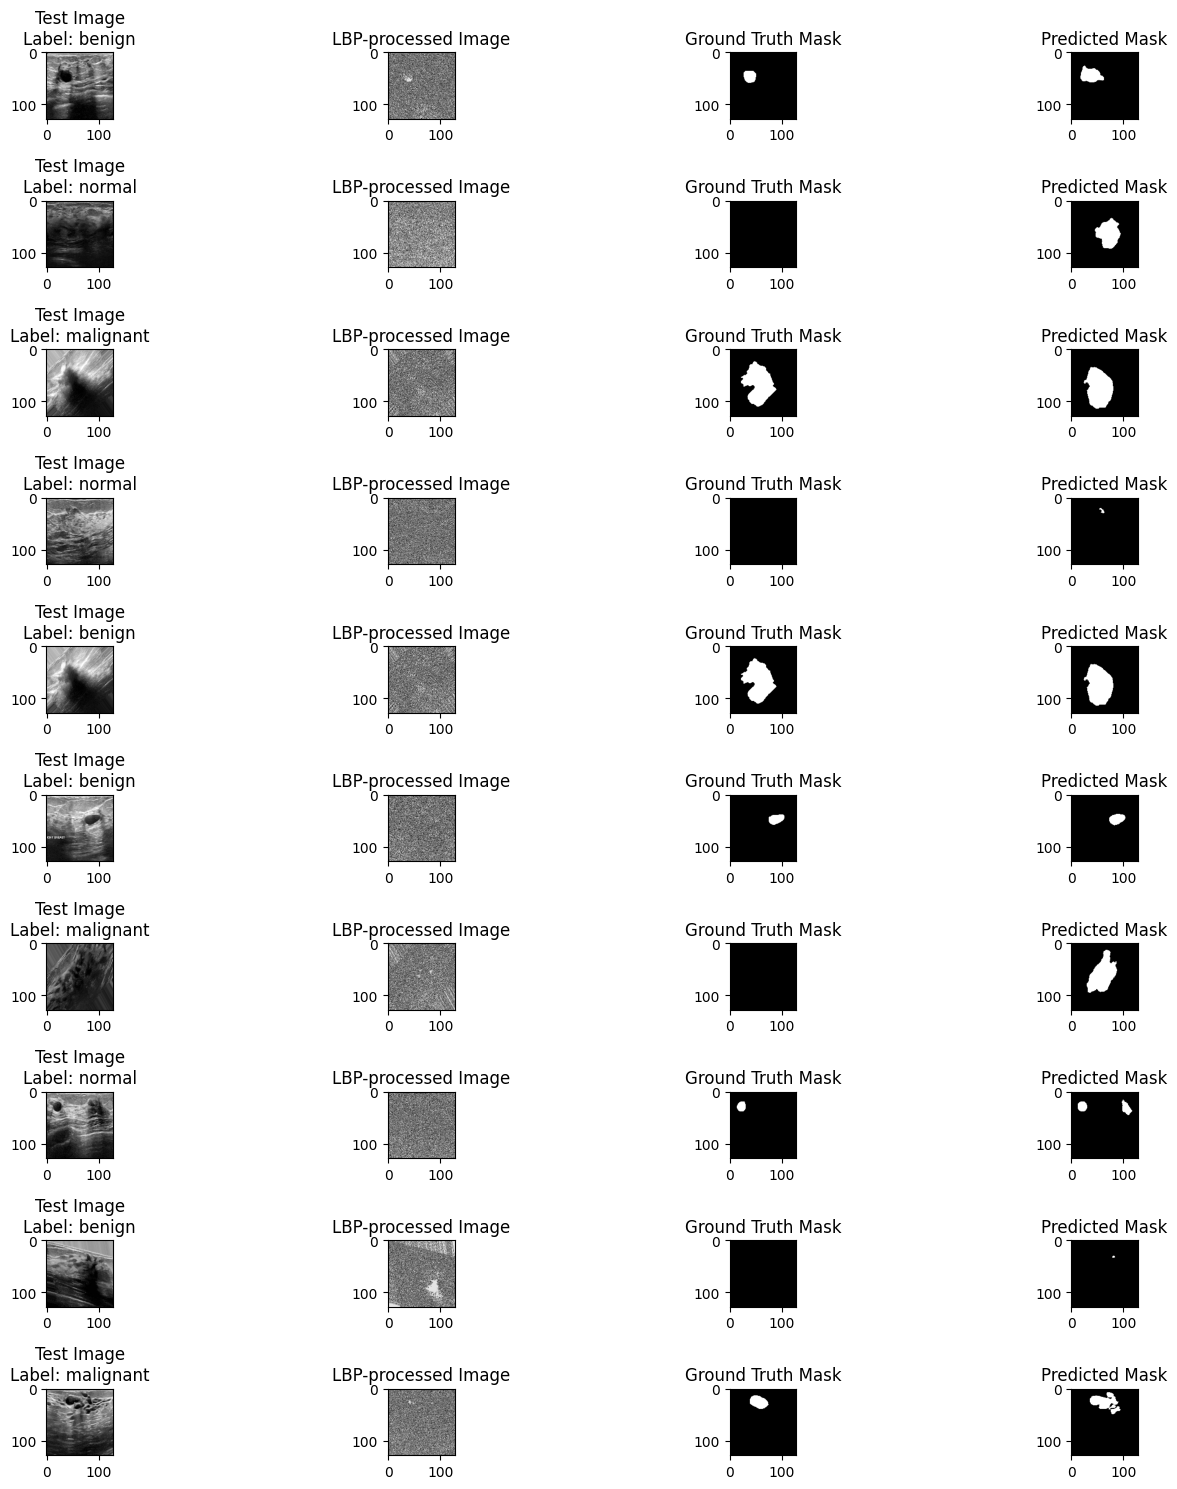

Average IoU: 0.7454288601875305
Average Dice Coefficient: nan
Average Precision: 0.44664719728689195
Average Recall: 0.4978530432287948
Average F1 Score: 0.4462205004676408


In [62]:
# Define the number of samples to visualize
num_samples_to_visualize = 10

# Create subplots for the original images, LBP-processed images, ground truth masks, and predicted masks
fig, axes = plt.subplots(num_samples_to_visualize, 4, figsize=(15, 15))

for i in range(num_samples_to_visualize):
    # Randomly select an index from the test data
    idx = np.random.randint(0, len(X_test_image))

    # Get the original image, LBP-processed image, ground truth mask, and predicted mask
    image = X_test_image[idx]
    lbp = X_test_lbp[idx]
    ground_truth_mask = y_test[idx]  # If you have ground truth masks
    predicted_mask = preds_test_t[idx]

    # Plot the original image
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title(f'Test Image\nLabel: {test_labels[idx]}')

    # Plot the LBP-processed image
    axes[i, 1].imshow(lbp[:, :, 0], cmap='gray')  # Assuming LBP has a single channel
    axes[i, 1].set_title("LBP-processed Image")

    # Plot the ground truth mask (if available)
    if ground_truth_mask is not None:
        axes[i, 2].imshow(ground_truth_mask[:, :, 0], cmap='gray')
        axes[i, 2].set_title("Ground Truth Mask")

    # Plot the predicted mask
    axes[i, 3].imshow(predicted_mask[:, :, 0], cmap='gray')
    axes[i, 3].set_title("Predicted Mask")

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

# Print the average metrics
print(f'Average IoU: {average_iou}')
print(f'Average Dice Coefficient: {average_dice}')
print(f'Average Precision: {average_precision}')
print(f'Average Recall: {average_recall}')
print(f'Average F1 Score: {average_f1}')

### Feature Extraction combined wiht resnet50(from scratch & pretrained)-Unet


In [121]:
n_classes = 1
activation = 'sigmoid' # 'softmax' for multi-class segmentation
lr = 0.0001
backbone = 'resnet50'
preprocess_input = sm.get_preprocessing(backbone)

In [14]:
# Process input for training data
X_train_lbp_norm = X_train_lbp / 255.0

# Concatenate the arrays along the last axis to create a 3-channel image
X_train_combined = np.concatenate([X_train_image, X_train_lbp_norm], axis=-1)

# Verify the shape of the combined image
print("Combined data shape:", X_train_combined.shape)

# Process input for test data
X_test_lbp_norm = X_test_lbp / 255.0

# Concatenate the arrays along the last axis to create a 3-channel image
X_test_combined = np.concatenate([X_test_image, X_test_lbp_norm], axis=-1)

# Verify the shape of the combined image
print("Combined data shape:", X_test_combined.shape)

Combined data shape: (715, 128, 128, 4)
Combined data shape: (179, 128, 128, 4)


(715, 128, 128, 4)

In [104]:
model = sm.Unet(backbone, input_shape = (None, None, 4), encoder_weights = None, classes = n_classes, activation=activation)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 4)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 4)        12        ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_104 (ZeroPa  (None, None, None, 4)        0         ['bn_data[0][0]']             
 dding2D)                                                                                         
                                                                                            

In [126]:
base_model = sm.Unet(backbone, encoder_weights='imagenet', classes = n_classes, activation=activation)
inp = Input(shape=(None, None, 4))
l1 = Conv2D(3, (1,1))(inp)
out = base_model(l1)
model = Model(inp, out, name = base_model.name)

In [127]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 4)]   0         
                                                                 
 conv2d_39 (Conv2D)          (None, None, None, 3)     15        
                                                                 
 model_12 (Functional)       (None, None, None, 1)     32561114  
                                                                 
Total params: 32561129 (124.21 MB)
Trainable params: 32513571 (124.03 MB)
Non-trainable params: 47558 (185.77 KB)
_________________________________________________________________


In [128]:
# Callbacks
# ModelCheckpoint: save after every epoch the model, only if it is better than the previous one
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/models/original_lbp_resnet50_pretrained_unet.h5', verbose = 1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs/original_lbp_resnet50_pretrained_unet/')
]

In [129]:
history = model.fit(X_train_combined,
                    y_train,
                    validation_split = 0.1,
                    batch_size = 8,
                    epochs = 50,
                    verbose = 1,
                    callbacks = callbacks)

Epoch 1/50
81/81 [==============================] - ETA: 0s - loss: 0.3212 - accuracy: 0.8783
Epoch 1: val_loss improved from inf to 0.35325, saving model to /content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/models/original_lbp_resnet50_pretrained_unet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 392s 5s/step - loss: 0.3212 - accuracy: 0.8783 - val_loss: 0.3533 - val_accuracy: 0.9395
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9384
Epoch 2: val_loss did not improve from 0.35325
81/81 [==============================] - 356s 4s/step - loss: 0.1733 - accuracy: 0.9384 - val_loss: 0.4002 - val_accuracy: 0.7940
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9437
Epoch 3: val_loss improved from 0.35325 to 0.17511, saving model to /content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/models/original_lbp_resnet50_pretrained_unet.h5
81/81 [==============================] - 359s 4s/step - loss: 0.1524 - accuracy: 0.9437 - val_loss: 0.1751 - val_accuracy: 0.9438
Epoch 4/50
81/81 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.9387
Epoch 4: val_loss did not improve from 0.17511
81/81 [==============================] - 346s 4s

In [15]:
model =load_model('/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/models/original_lbp_resnet50_pretrained_unet.h5')

In [16]:


X_train_2 = X_train_combined[:int(X_train_combined.shape[0]*0.9)]
X_val = X_train_combined[int(X_train_combined.shape[0]*0.9):]

# Predict using X_train, and 0.1 of X_train as validation, and X_test
preds_train = model.predict(X_train_2, verbose =1)
preds_val = model.predict(X_val, verbose =1)
preds_test = model.predict(X_test_combined, verbose =1)

# Threshold the predicted mask to create binary masks
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

6/6 [==============================] - 26s 4s/step


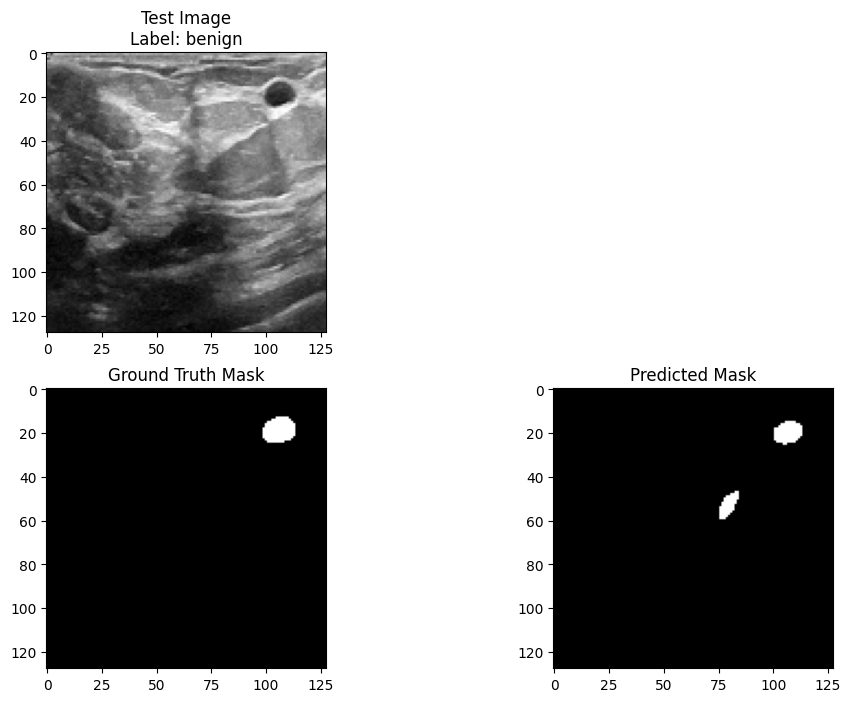

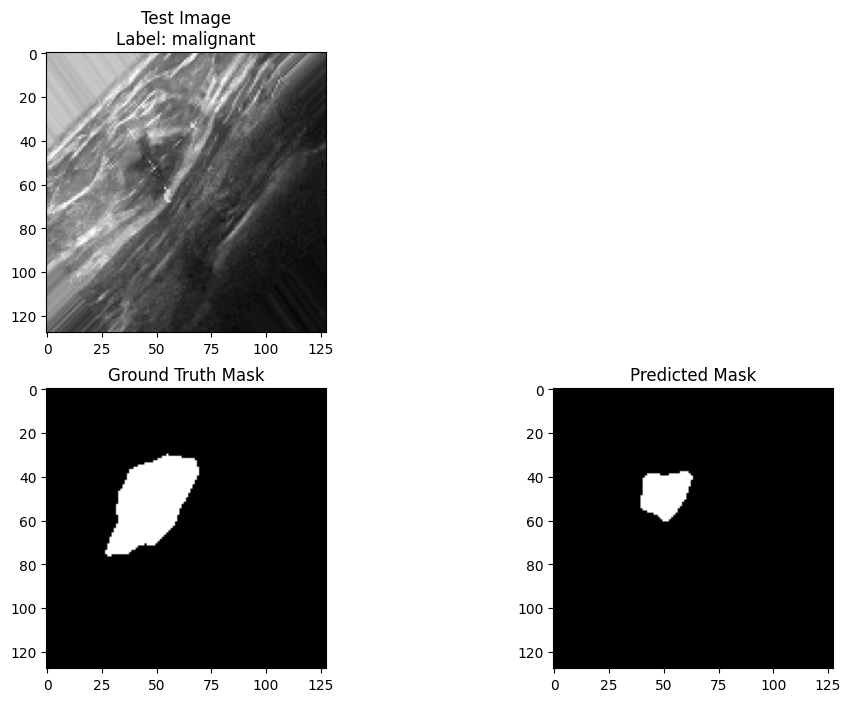

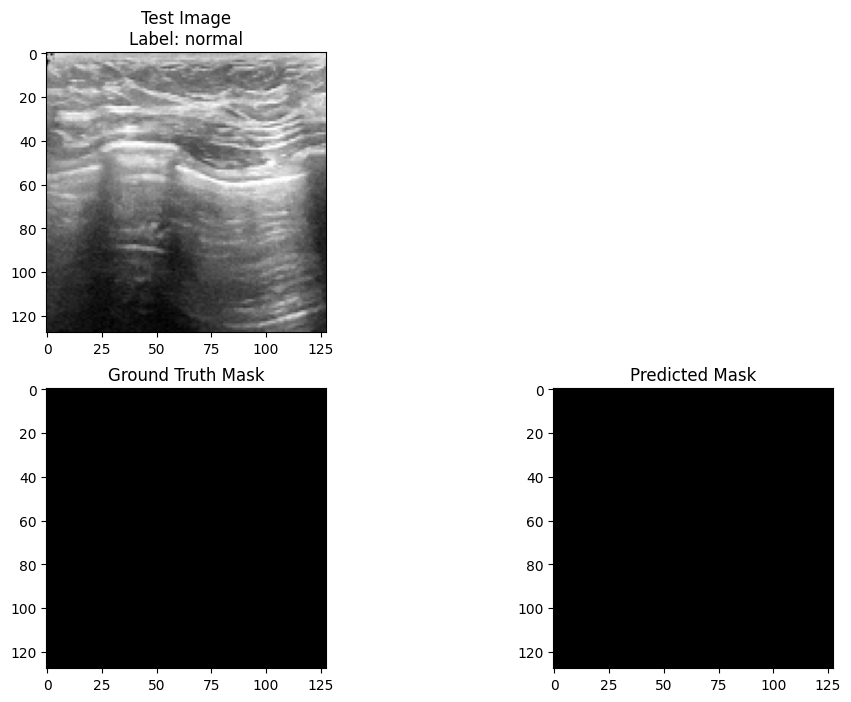

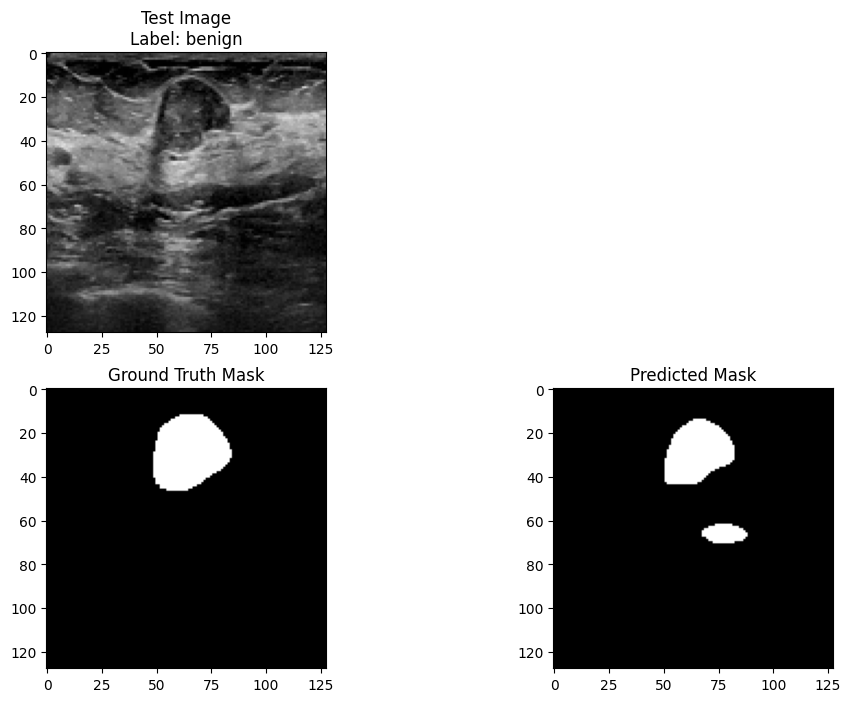

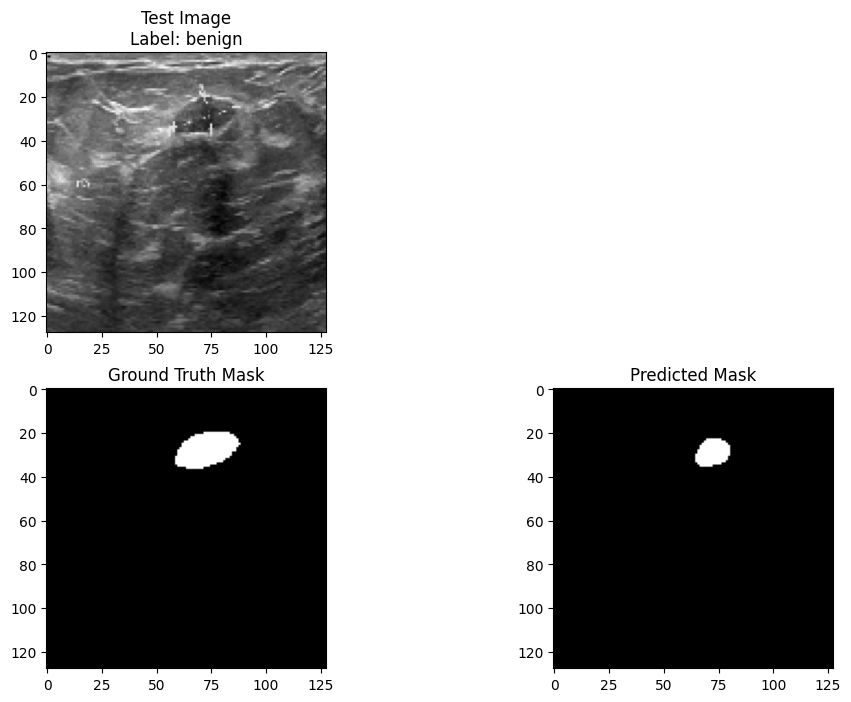

In [17]:
# Visualize some results
num_samples_to_visualize = 5

for i in range(num_samples_to_visualize):
    # Select a random sample index
    sample_index = np.random.randint(0, len(X_test_combined))

    # Get the original and combined images
    original_image = X_test_image[sample_index]
    #combined_image = X_test_combined[sample_index]

    # Get the ground truth mask and predicted mask
    ground_truth_mask = y_test[sample_index]  # Assuming you have ground truth masks
    predicted_mask = preds_test_t[sample_index]

    # Plot the original image, combined image, ground truth mask, and predicted mask
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(original_image)
    plt.title(f'Test Image\nLabel: {test_labels[sample_index]}')

    #plt.subplot(2, 2, 2)
    #plt.imshow(combined_image)
    #plt.title("Combined Image")

    plt.subplot(2, 2, 3)
    plt.imshow(ground_truth_mask[:, :, 0], cmap='gray')  # Assuming binary masks
    plt.title("Ground Truth Mask")

    plt.subplot(2, 2, 4)
    plt.imshow(predicted_mask[:, :, 0], cmap='gray')  # Assuming binary masks
    plt.title("Predicted Mask")

    plt.show()

In [18]:
# Calculate evaluation metrics on
iou = []
dice = []
precision = []
recall = []
f1 = []

for i in range(len(X_test_combined)):
    iou.append(tf.keras.metrics.MeanIoU(num_classes=2)(y_test[i], preds_test_t[i]).numpy())
    dice.append(2 * np.sum(y_test[i] * preds_test_t[i]) / (np.sum(y_test[i]) + np.sum(preds_test_t[i])))
    precision.append(precision_score(y_test[i].flatten(), preds_test_t[i].flatten()))
    recall.append(recall_score(y_test[i].flatten(), preds_test_t[i].flatten()))
    f1.append(f1_score(y_test[i].flatten(), preds_test_t[i].flatten()))

# Calculate the average metrics
average_iou = np.mean(iou)
average_dice = np.mean(dice)
average_precision = np.mean(precision)
average_recall = np.mean(recall)
average_f1 = np.mean(f1)

print(f'Average IoU: {average_iou}')
print(f'Average Dice Coefficient: {average_dice}')
print(f'Average Precision: {average_precision}')
print(f'Average Recall: {average_recall}')
print(f'Average F1 Score: {average_f1}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-18-f7d316898673>:10: RuntimeWarning: invalid value encountered in double_scalars
  dice.append(2 * np.sum(y_test[i] * preds_test_t[i]) / (np.sum(y_test[i]) + np.sum(preds_test_t[i])))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this b

Average IoU: 0.7484967708587646
Average Dice Coefficient: nan
Average Precision: 0.4870951275359897
Average Recall: 0.36087027166181135
Average F1 Score: 0.37221636574756983


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-18-f7d316898673>:10: RuntimeWarning: invalid value encountered in double_scalars
  dice.append(2 * np.sum(y_test[i] * preds_test_t[i]) / (np.sum(y_test[i]) + np.sum(preds_test_t[i])))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.